In [1]:
import os
import os.path as op
from IPython.display import Image

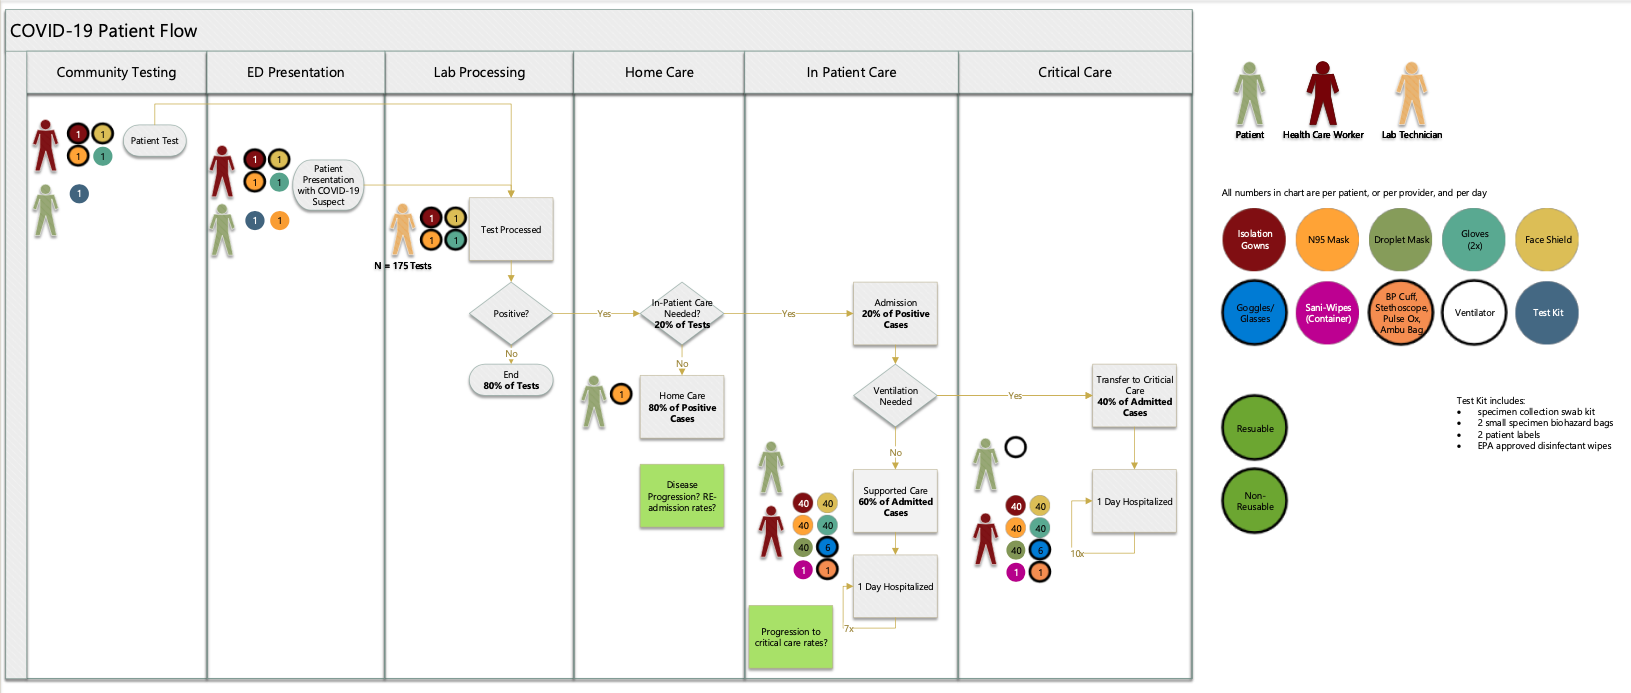

In [2]:
fig_path = "../../figs/"
with open(op.join(fig_path,'covid19_patient_flow_ppes_needs.png'),'rb') as f:
    display(Image(data=f.read(), format='png'))

## Input data

Input data needs to be divided into two groups:

- patients group a who go to community testing;
- patients group b who go to ED presentation;

Ideally, the patients can be daily tracking by each state or hospital. It can be the simulation number that comes from a predictive model, e.g. [SEIR model](https://github.com/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb)

In [6]:
# setting at one, so we can read in confirmed case daily from multiple sources
# in this workthough, we used data from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

confirmed_case = 1

# one health provider testing 10 patient perday
testing_ratio = 6

positive_rate = 0.2

inpatient_rate = 0.2
homecare_rate = 1- inpatient_rate
test_cases = round(confirmed_case / positive_rate)


critical_rate = 0.25
support_care = 0.75

inpatient_care_days = 7
critical_care_days = 14

## patient to lab technician and healthcare workers
patient_tech_ratio = 170


# PPE use per patients per day from in patient to critical care
# room_entries: times / day
nurse_re = 6
doc_re = 1.2
evs_re = 1
clinic_doc_re = 1
phle_re = 1.5

shift_per_day = 2

# patients to health provider ratio
p2nurse = 2
p2doc = 10
p2evs = 20
p2clinic = 10
p2phle = 10 

#ppe use by technician (ever 170 patiens)
ppe_use_tech = 6 
# light_ppe_use = 1
double = 2


In [43]:
def ppes_ed_OB(patients, testing_ratio):
    """compute PPEs include (N95, gloves, gown, testkit, face shield and ventilator) 
    base on patients and healthcareworkersâ€™ cosupution in ED or community testing 
    
    Args:
        patients (int): number of comfirmed cases

    Returns:
        total_ppes_ed_comm (dictionary): PPE needs for ED presentation or community testing
    """
    test_cases = round(patients / positive_rate)
    # every 30 patients were taked care by 5 healthe providers
    healthcareworkers = test_cases/testing_ratio
    droplet_masks = healthcareworkers 
    n95_needs =  healthcareworkers *double
    gloves = healthcareworkers *double
    testkits =  test_cases
    gowns =  healthcareworkers
    total_ppes_ed_comm = dict(N95s= n95_needs, Droplet_masks = droplet_masks, 
                              Gloves =gloves, Testkits = testkits, Gowns=gowns)
    
    return total_ppes_ed_comm


def ppes_lab_processing(patients,positive_rate): 
    """to compute the ppes needs during the lab processing
    Args:
        patients (int): number of total comfirmed cases from community test and ED presentation;
        
    Returns:
        total_ppes_lab (dictionary): PPE needs for lab processing
    """
    test_cases = round(patients / positive_rate)
    technicians = test_cases/patient_tech_ratio # each technician can run 170 test per day. 
    evs = test_cases/patient_tech_ratio

    droplet_masks = (technicians * ppe_use_tech +  evs ) 
    gloves =  (technicians * ppe_use_tech +  evs )  * double
    gowns =  technicians +  evs  


    total_ppes_lab = dict(Droplet_masks= droplet_masks,
                          Gloves= gloves, Gowns=gowns)

    return total_ppes_lab



def ppes_in_patient_care(patients, inpatient_care_days):
    """to compute ppe needs during in patient care
    Args:
        patients (int): number of total patients from community test and ED presentation;
        in_patients_days(int): number of days each person will need to be in Patient Care
        
    Returns:
        total_ppes_in_patient (dictionary): PPE needs for in patient care
    """

    # 20% endup being positive and 20% of these in patient care
    in_patient_patients = patients * inpatient_rate
    
    # number of health providers each day
    # can't use this to represent the health providers, cause we multiply the room entries
    nurses = in_patient_patients/p2nurse * shift_per_day * nurse_re
    docs = in_patient_patients/p2doc * shift_per_day * doc_re
    evss = in_patient_patients/p2evs * evs_re
    clinicians = in_patient_patients/p2doc * shift_per_day * clinic_doc_re
    phles = in_patient_patients/ p2phle * shift_per_day * phle_re
    
    #total health provider
    hps = sum([nurses, docs, clinicians, phles])
    
    
    gloves = (hps *double + evss * double ) * inpatient_care_days 
    droplet_masks = (hps  +  evss * double )* inpatient_care_days
    gowns = (hps +  evss * double )* inpatient_care_days 
    
    # goggle can be reused
    goggles = (hps +  evss * double )*double  
    
    bp_cuff = in_patient_patients # bp cuff, ambu bag can be reused
    wipers = in_patient_patients * inpatient_care_days 

    total_ppes_in_patient = dict(Gloves= gloves, Gowns=gowns, Droplet_masks= droplet_masks,
                                Goggles = goggles, BP_cuff = bp_cuff, Wiper = wipers)

    return total_ppes_in_patient


def ppes_critical_care(patients, critical_care_days):
    """compute the ventilators and ppe needs based on the critical care patients
    Args:
        patients (int): number of total patients from community test and ED presentation;
        in_patients_days(int): number of days each person will need to be in Critical Care
        
    Returns:
        total_ppes_criticalcare (dictionary): PPE needs for in critical care
    """

    # 40% of in patient patients end up in critical care
    critical_care_patients = patients * positive_rate * critical_rate
    
    ventilators = critical_care_patients
    
    # twice room entrences compares to in-patient care
    nurses = critical_care_patients/p2nurse * shift_per_day * nurse_re * double
    docs = critical_care_patients/p2doc * shift_per_day * doc_re  * double
    evss = critical_care_patients/p2evs * evs_re  * double
    clinicians = critical_care_patients/p2doc * shift_per_day * clinic_doc_re  * double
    phles = critical_care_patients/ p2phle * shift_per_day * phle_re * double
    
    hps = sum([nurses, docs, clinicians, phles])
   
    
    gloves = (hps + evss * double) * critical_care_days
    droplet_masks = (hps +  evss * double )* critical_care_days 
    gowns = (hps +  evss * double) * critical_care_days 
    n95_needs = (hps +  evss * double )*double * critical_care_days
    
    # goggle can be reused
    goggles = (hps +  evss * double )*double 
    
    bp_cuff = critical_care_patients # bp cuff, ambu bag can be reused
    wipers = critical_care_patients * critical_care_days 

    total_ppes_criticalcare = dict(N95s = n95_needs, Gloves= gloves, Gowns=gowns, 
                                  Droplet_masks= droplet_masks, Goggles = goggles, 
                                  BP_cuff = bp_cuff, Wiper = wipers,
                                  Ventilators = ventilators)
    
    return total_ppes_criticalcare




In [44]:
total_ppes_ed = ppes_ed_OB(confirmed_case, testing_ratio)
total_ppes_ed

{'N95s': 1.6666666666666667,
 'Droplet_masks': 0.8333333333333334,
 'Gloves': 1.6666666666666667,
 'Testkits': 5,
 'Gowns': 0.8333333333333334}

In [45]:
total_ppes_lab = ppes_lab_processing(confirmed_case,  positive_rate)
total_ppes_lab

{'Droplet_masks': 0.20588235294117646,
 'Gloves': 0.4117647058823529,
 'Gowns': 0.058823529411764705}

In [46]:
total_ppes_in_patient = ppes_in_patient_care(confirmed_case, inpatient_care_days)
total_ppes_in_patient

{'Gloves': 19.012000000000004,
 'Gowns': 9.576000000000002,
 'Droplet_masks': 9.576000000000002,
 'Goggles': 2.7360000000000007,
 'BP_cuff': 0.2,
 'Wiper': 1.4000000000000001}

In [47]:
total_ppes_criticalcare = ppes_critical_care(confirmed_case, critical_care_days)
total_ppes_criticalcare

{'N95s': 19.152000000000005,
 'Gloves': 9.576000000000002,
 'Gowns': 9.576000000000002,
 'Droplet_masks': 9.576000000000002,
 'Goggles': 1.3680000000000003,
 'BP_cuff': 0.05,
 'Wiper': 0.7000000000000001,
 'Ventilators': 0.05}

In [48]:
# for every confirmed convid19 case from home in patient and critical cares 
testkits = total_ppes_ed['Testkits']
droplet_masks =  total_ppes_ed['Droplet_masks'] + total_ppes_lab['Droplet_masks'] + total_ppes_in_patient['Droplet_masks'] + total_ppes_criticalcare['Droplet_masks']
n95s = total_ppes_ed['N95s'] + total_ppes_criticalcare['N95s'] 
gloves = total_ppes_ed['Gloves']+ total_ppes_lab['Gloves'] + total_ppes_in_patient['Gloves'] + total_ppes_criticalcare['Gloves']  
gowns = total_ppes_ed['Gowns']+ total_ppes_lab['Gowns'] + total_ppes_in_patient['Gowns'] + total_ppes_criticalcare['Gowns'] 
goggles = total_ppes_in_patient['Goggles'] + total_ppes_criticalcare['Goggles']
bp_cuffs = total_ppes_in_patient['BP_cuff'] + total_ppes_criticalcare['BP_cuff']
wipers = total_ppes_in_patient['Wiper'] + total_ppes_criticalcare['Wiper']
ventilators = total_ppes_criticalcare['Ventilators']

In [49]:
total_ppes = round(sum([n95s, gloves, gowns,
                        droplet_masks, goggles, bp_cuffs, wipers]))

In [50]:
total_ppes

98

In [51]:
ventilators

0.05

In [52]:
testkits

5